In [1]:
from fbm_dropout.net import DenseNet, DenseNetFBM_with_branching
import torch.optim as optim
import torch.nn as nn

hidden_sizes = [256, 64]
grid_sizes = [(16,16), (8,8)]
n_agents = [24, 12]
device='cuda'

model = DenseNet(hidden_sizes, 0, device=device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model_dropout = DenseNet(hidden_sizes, .20, device=device)
optimizer_dropout = optim.Adam(model_dropout.parameters(), lr=0.001)

model_fbm_dropout = DenseNetFBM_with_branching(hidden_sizes, n_agents, 100, 1000, 10, grid_sizes, show=False, device=device)
optimizer_fbm_dropout = optim.Adam(model_fbm_dropout.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

In [2]:
import torch
from fbm_dropout.dataset import get_MNIST_dataset

trainset, testset = get_MNIST_dataset()
batch_size = 64
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [3]:
results = {}
results['train loss'] = {}
results['train loss']['no dropout'] = []
results['train loss']['dropout'] = []
results['train loss']['fbm dropout'] = []
results['test acc'] = {}
results['test acc']['no dropout'] = []
results['test acc']['dropout'] = []
results['test acc']['fbm dropout'] = []
for epoch in range(10):
    model.train()
    model_dropout.train()
    model_fbm_dropout.train()

    running_loss = {}
    running_loss['no dropout'] = running_loss['dropout'] = running_loss['fbm dropout'] = 0.0
    for images, labels in train_loader:

        images = images.view(images.shape[0], -1).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        optimizer_dropout.zero_grad()
        optimizer_fbm_dropout.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss['no dropout'] += loss.item()

        output_dropout = model_dropout(images)
        loss_dropout = criterion(output_dropout, labels)
        loss_dropout.backward()
        optimizer_dropout.step()
        running_loss['dropout'] += loss_dropout.item()

        output_fbm_dropout = model_fbm_dropout(images)
        loss_fbm_dropout = criterion(output_fbm_dropout, labels)
        loss_fbm_dropout.backward()
        optimizer_fbm_dropout.step()
        running_loss['fbm dropout'] += loss_fbm_dropout.item()

    results['train loss']['no dropout'].append(running_loss['no dropout'] / len(train_loader))
    results['train loss']['dropout'].append(running_loss['dropout'] / len(train_loader))
    results['train loss']['fbm dropout'].append(running_loss['fbm dropout'] / len(train_loader))

    model.eval()
    model_dropout.eval()
    model_fbm_dropout.eval()
    acc = acc_dropout = acc_fbm_dropout = 0.0
    for images, labels in test_loader:
        images = images.view(-1,784).to(device)
        labels = labels.to(device)
        output = model(images)
        _, pred = torch.max(output, axis=1)
        acc += torch.sum(pred==labels).item()

        output_dropout = model_dropout(images)
        _, pred_dropout = torch.max(output_dropout, axis=1)
        acc_dropout += torch.sum(pred_dropout==labels).item()

        output_fbm_dropout = model_fbm_dropout(images)
        _, pred_fbm_dropout = torch.max(output_fbm_dropout, axis=1)
        acc_fbm_dropout += torch.sum(pred_fbm_dropout==labels).item()
    
    results['test acc']['no dropout'].append(acc / len(testset))
    results['test acc']['dropout'].append(acc_dropout / len(testset))
    results['test acc']['fbm dropout'].append(acc_fbm_dropout / len(testset))

    model_fbm_dropout.dropout_1.branch_off()
    model_fbm_dropout.dropout_2.branch_off()

    
    print('Epoch {}'.format(epoch))
    print('No Dropout : Train Loss {:.4f}, Test Acc {:.4f}'.format(results['train loss']['no dropout'][-1], results['test acc']['no dropout'][-1]))
    print('Dropout    : Train Loss {:.4f}, Test Acc {:.4f}'.format(results['train loss']['dropout'][-1], results['test acc']['dropout'][-1]))
    print('FBM Dropout: Train Loss {:.4f}, Test Acc {:.4f}, Drop Rate {:.4f} {:.4f}'.format(results['train loss']['fbm dropout'][-1], 
                                                                                        results['test acc']['fbm dropout'][-1], 
                                                                                        model_fbm_dropout.dropout_1.cum_dropout_rate, 
                                                                                        model_fbm_dropout.dropout_2.cum_dropout_rate))

Epoch 0
No Dropout : Train Loss 0.3625, Test Acc 0.9398
Dropout    : Train Loss 0.4405, Test Acc 0.9384
FBM Dropout: Train Loss 0.5114, Test Acc 0.9255, Drop Rate 0.1831 0.1994
Epoch 1
No Dropout : Train Loss 0.1650, Test Acc 0.9570
Dropout    : Train Loss 0.2207, Test Acc 0.9569
FBM Dropout: Train Loss 0.2427, Test Acc 0.9512, Drop Rate 0.1829 0.2020
Epoch 2
No Dropout : Train Loss 0.1202, Test Acc 0.9634
Dropout    : Train Loss 0.1763, Test Acc 0.9625
FBM Dropout: Train Loss 0.1920, Test Acc 0.9608, Drop Rate 0.1842 0.2020
Epoch 3
No Dropout : Train Loss 0.0971, Test Acc 0.9649
Dropout    : Train Loss 0.1508, Test Acc 0.9655
FBM Dropout: Train Loss 0.1610, Test Acc 0.9633, Drop Rate 0.1844 0.2028
Epoch 4
No Dropout : Train Loss 0.0810, Test Acc 0.9709
Dropout    : Train Loss 0.1363, Test Acc 0.9692
FBM Dropout: Train Loss 0.1457, Test Acc 0.9670, Drop Rate 0.1850 0.2029
Epoch 5
No Dropout : Train Loss 0.0708, Test Acc 0.9744
Dropout    : Train Loss 0.1263, Test Acc 0.9700
FBM Dropout

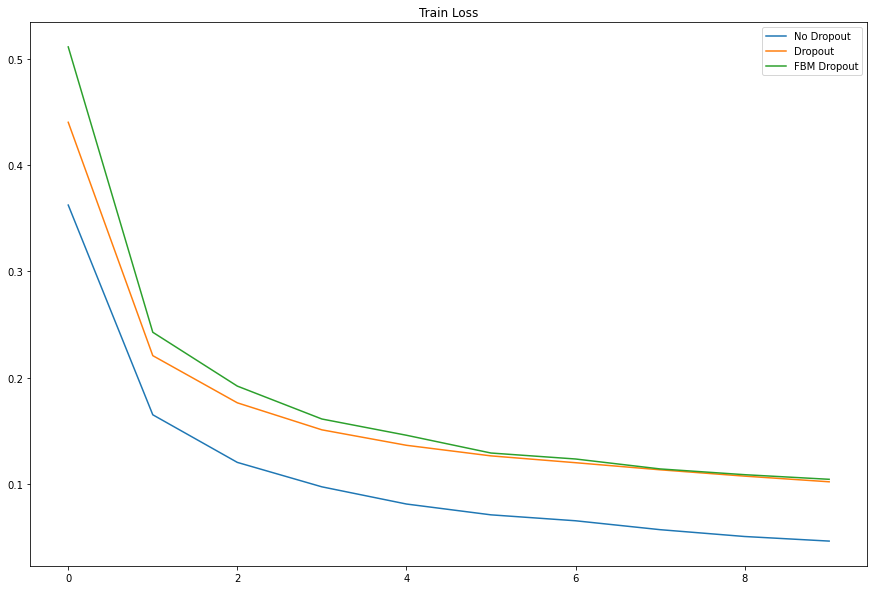

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(results['train loss']['no dropout'], label='No Dropout')
plt.plot(results['train loss']['dropout'], label='Dropout')
plt.plot(results['train loss']['fbm dropout'], label='FBM Dropout')
plt.title('Train Loss')
plt.legend()
plt.show()

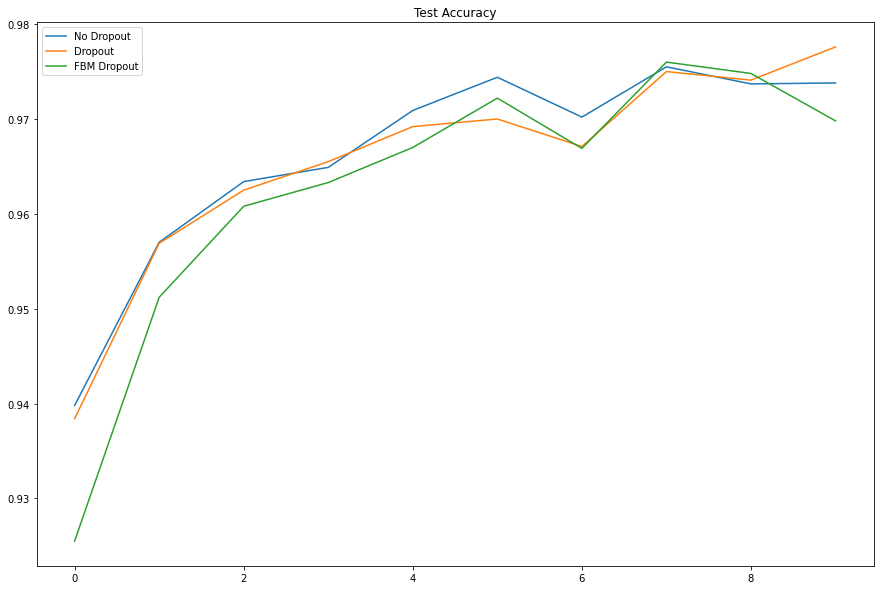

In [5]:
plt.figure(figsize=(15,10))
plt.plot(results['test acc']['no dropout'], label='No Dropout')
plt.plot(results['test acc']['dropout'], label='Dropout')
plt.plot(results['test acc']['fbm dropout'], label='FBM Dropout')
plt.title('Test Accuracy')
plt.legend()
plt.show()